# Process Mining Module - PDEng program Data Science

This notebook is part of the Process Mining module of the JADS PDEng program on Data Science. It accompanies Lecture 1 on *Event Logs and Process Discovery*. The collection of notebooks is a *living document* and subject to change. 

# Lecture 2 - 'Process Discovery with the Heuristics Miner' (Python / PM4Py)

* **Responsible Lecturer**: Dr. Felix Mannhardt, [@fmannhardt](https://twitter.com/fmannhardt)
* **Last Update**: 28th April 2021

## Setup

<img src="https://pm4py.fit.fraunhofer.de/static/assets/images/pm4py-site-logo-padded.png" alt="PM4Py" style="width: 200px;"/>

In this notebook, we are using the [PM4Py library](https://pm4py.fit.fraunhofer.de/) in combination with several standard Python data science libraries:

* [pandas](https://pandas.pydata.org/)
* [plotnine](https://plotnine.readthedocs.io/en/stable/)

In [1]:
## Perform the commented out commands to install the dependencies
# %pip install pandas
# %pip install matplotlib
# %pip install pm4py

In [2]:
import pandas as pd
import pm4py
import plotnine
from plotnine import ggplot, geom_point, aes, theme_bw, coord_flip, scale_y_discrete, theme, element_text, geom_bin2d

## Process Discovery

### Process Models

A common industry standard for Process Model is [BPMN](https://www.bpmn.org/), which can be created by web-based tools like [BPMN.io](https://bpmn.io/) and loaded and used by PM4Py.

In [7]:
import pm4py
import os

bpmn_graph = pm4py.read_bpmn(os.path.join("..", "data", "sepsis.bpmn"))

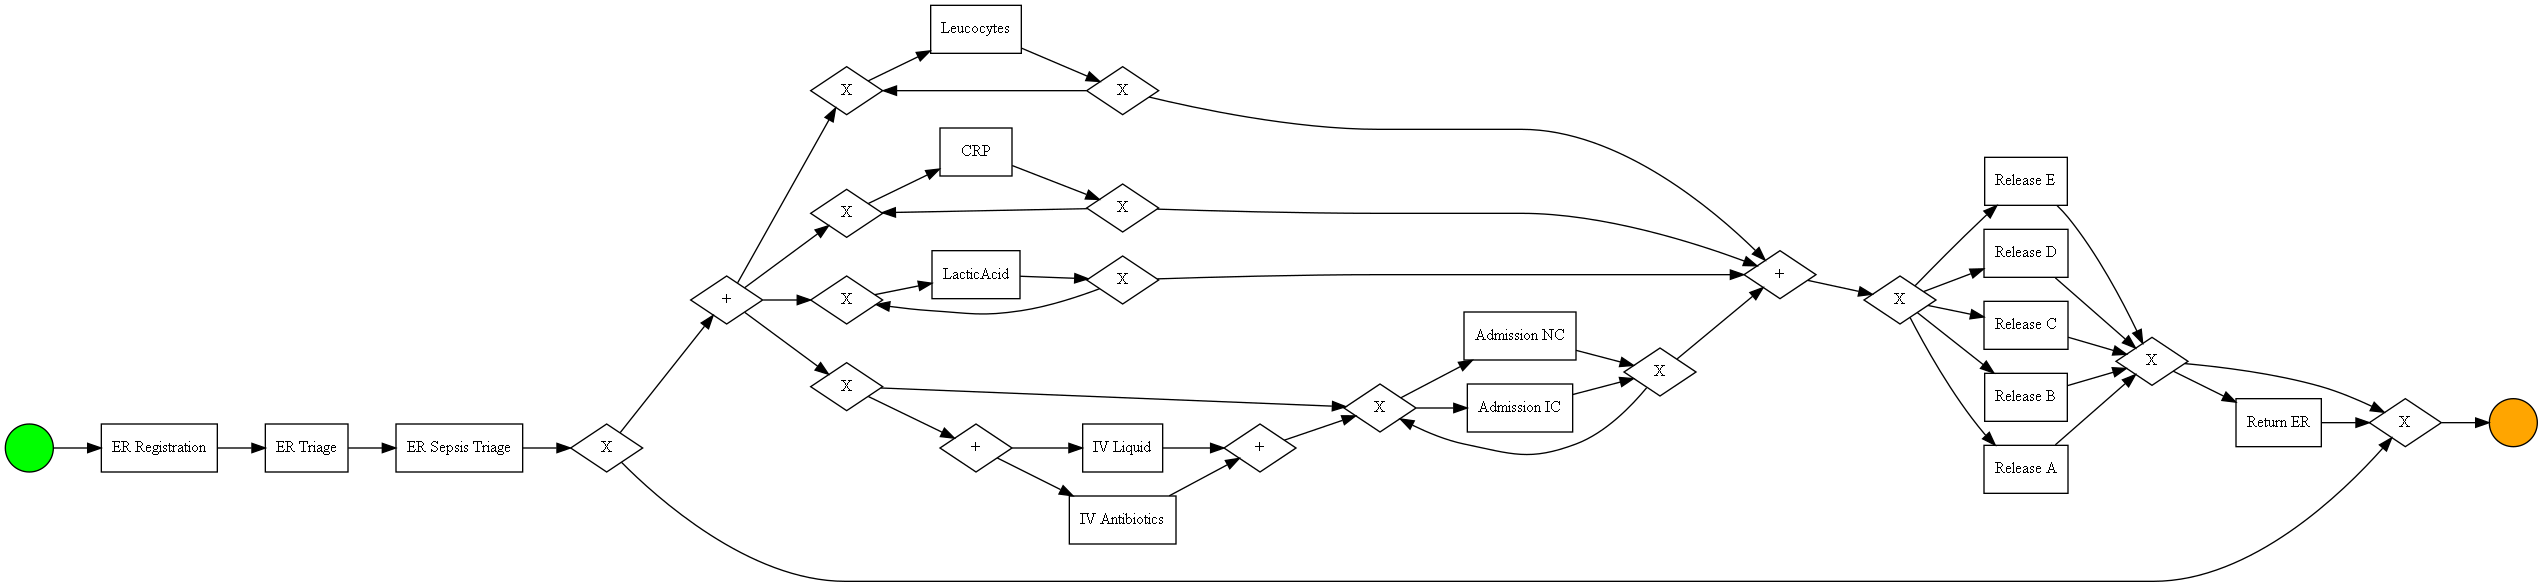

In [8]:
pm4py.vis.view_bpmn(bpmn_graph)

### Quality Dimensions

The quality dimensions `fitness`, `precision`, `simplicity`, and `generalisation` are best illustrated by using a small example event log.
We are using an example event log in XES format that is used in the book `Process Mining - Data Science in Action` by Wil van der Aalst, which is downloaded and stored in the `../data` directory with the code below:

In [9]:
# Just to be able to download and extract the file
def load_file_from_zip(url, file, target):
    from io import BytesIO
    from urllib.request import urlopen
    from zipfile import ZipFile        
    with urlopen(url) as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            zipInfo = zfile.getinfo(file)
            zipInfo.filename = os.path.basename(target)
            zfile.extract(zipInfo, os.path.dirname(os.path.realpath(target)))

load_file_from_zip('http://www.processmining.org/_media/processminingbook/chapter_7.zip', 'Chapter_7/Lfull.xes', '../data/Lfull.xes')

In [10]:
from pm4py.objects.log.importer.xes import importer as xes_importer
example_log = xes_importer.apply('../data/Lfull.xes')

parsing log, completed traces ::   0%|          | 0/1391 [00:00<?, ?it/s]

Let us have a look at the event log in tabular form. The mapping of the activity labels to actual activities is:

* a = register request, 
* b = examine thoroughly, 
* c = examine casually, 
* d = check ticket, 
* e = decide, 
* f = reinitiate request, 
* g = pay compensation, and 
* h = reject request.

In [11]:
pm4py.convert_to_dataframe(example_log)

,org:resource,time:timestamp,concept:name,lifecycle:transition,case:concept:name
0,UNDEFINED,2010-11-09 13:03:41.887000+01:00,a,complete,Case1.290
1,UNDEFINED,2010-11-09 13:04:41.887000+01:00,c,complete,Case1.290
2,UNDEFINED,2010-11-09 13:05:41.887000+01:00,d,complete,Case1.290
3,UNDEFINED,2010-11-09 13:06:41.887000+01:00,e,complete,Case1.290
4,UNDEFINED,2010-11-09 13:07:41.887000+01:00,h,complete,Case1.290
...,...,...,...,...,...
7534,UNDEFINED,2010-11-09 13:03:41.903000+01:00,a,complete,Case2.71
7535,UNDEFINED,2010-11-09 13:04:41.903000+01:00,b,complete,Case2.71
7536,UNDEFINED,2010-11-09 13:05:41.903000+01:00,d,complete,Case2.71
7537,UNDEFINED,2010-11-09 13:06:41.903000+01:00,e,complete,Case2.71


Now let us discover a process map as we have seen in Lecture 1:

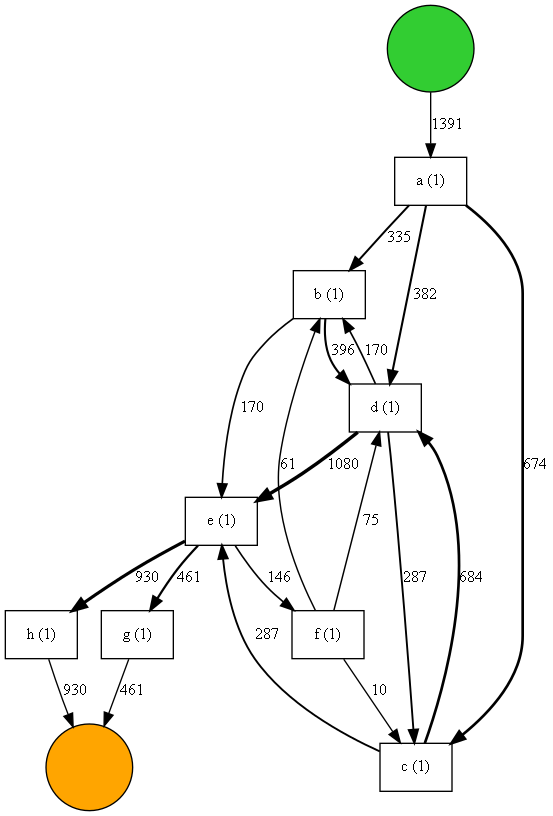

In [12]:
pm4py.view_dfg(*pm4py.discover_directly_follows_graph(example_log))

Not really very insightful the directly-follows based process map visualization.

#### Four Process Models - One Event Log 🚧

This part is under construction.

### Heuristics Miner 🚧

In [13]:
L_heur_1 = pd.read_csv("../data/L_heur_1.csv", sep=';')
num_rows = len(L_heur_1)
print("Number of rows: {}".format(num_rows))
L_heur_1_log = pm4py.format_dataframe(L_heur_1, case_id='CASE_concept_name', activity_key='activity_id', timestamp_key='timestamp')

Number of rows: 139


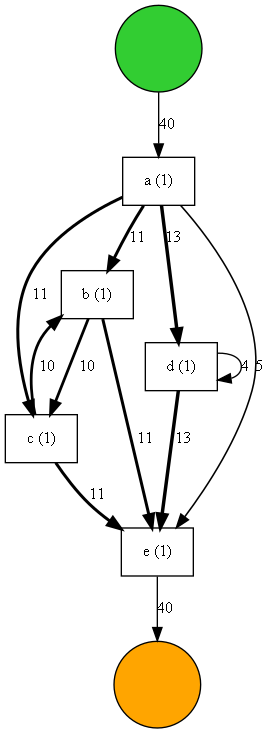

In [14]:
dfg, sa, ea = pm4py.discover_directly_follows_graph(L_heur_1_log)
pm4py.view_dfg(dfg, sa, ea)

### Dependency Graph 🚧

In PM4Py, there is no option to review the intermediate data structures used for the Heuristics Miner such as the dependency graph.

🚧

### Causal net

The Causal net formalism is called `Heuristics Net` in PM4Py along with the definitions used in the original paper that proposed the Heuristics Miner.

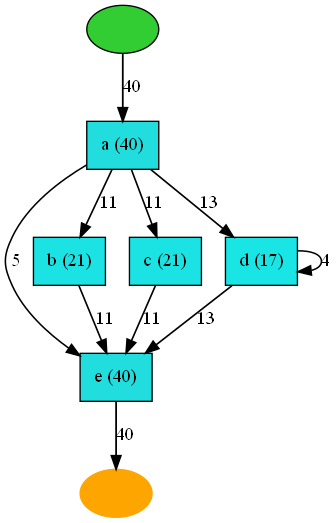

In [15]:
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner

# due to bug here: https://github.com/pm4py/pm4py-core/issues/220
# we need to convert this to a event log object

L_heur_1_log = pm4py.convert_to_event_log(L_heur_1_log)
L_heur_1_map = pm4py.discover_heuristics_net(L_heur_1_log, dependency_threshold = 0.8, and_threshold = 0.65,  loop_two_threshold = 0.5)
pm4py.view_heuristics_net(L_heur_1_map)

#### Convert to BPMN

In [16]:
from pm4py.objects.conversion.wf_net.variants import to_bpmn

# we need to have an intermediate step to get a Petri net
L_heur_1_petrinet, im, fm = pm4py.convert_to_petri_net(L_heur_1_map)
L_heur_1_bpmn = to_bpmn.apply(L_heur_1_petrinet, im, fm)

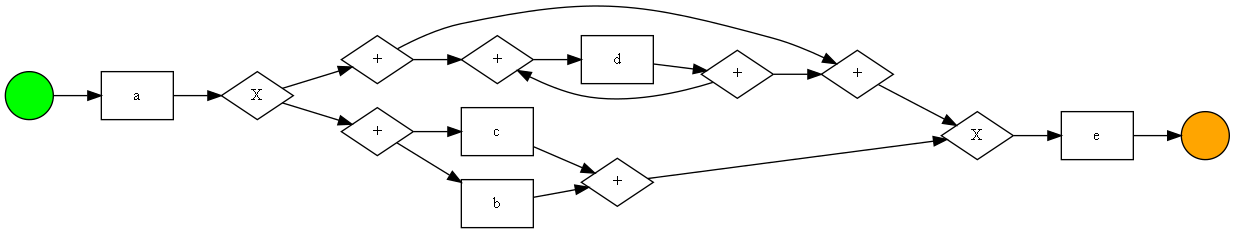

In [17]:
pm4py.view_bpmn(L_heur_1_bpmn)